In [19]:
from __future__ import print_function
import pdb, math
import matplotlib.pyplot as plt
import numpy as np
import torch
import pdb
plt.rcParams["figure.figsize"] = (12,12)

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [2]:
class SDF(nn.Module):
    def __init__(self):
        super(SDF, self).__init__()
        self.fc1 = nn.Linear(3, 512)
        self.drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 512)     
        self.fc6 = nn.Linear(512, 1)
        
    def forward(self, x):
#         pdb.set_trace()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [3]:
H = 300
W = 300

ORIGIN = torch.from_numpy(np.array([0,0,-5]))

EPSILON = 0.01
INNER_STEP = .01

class DetectorSquare():
    def __init__(self, origin, h=100, w=120, z=0):
        self.h, self.w = h, w
        self.r = float(self.w) / self.h
        self.x1, self.x2, self.y1, self.y2, self.z1, self.z2 = -1, 1, -1. / self.r + .25, 1. / self.r + .25, z, -z
        self.xes = np.linspace(self.x1, self.x2, self.w)
        self.yes = np.linspace(self.y1, self.y2, self.h)

# origin is at -5, getector is at 5 placing objects in the middle        
detector = DetectorSquare(ORIGIN, h=H, w=W, z=5)

In [4]:
#rays from origin to correcponsing point on the detector place
rays = np.stack((detector.xes[:,None].repeat(detector.h,axis=1), 
                 detector.yes[:,None].repeat(detector.w,axis=1).transpose(), 
                 torch.zeros((detector.w,detector.h))))
rays = torch.from_numpy(rays).float().to('cuda')

In [5]:
rays.shape

torch.Size([3, 300, 300])

In [6]:
#unit vectors from origin to detector plane
vectors = rays - torch.from_numpy(ORIGIN.numpy()[:,None,None]).float().to('cuda')

In [7]:
#starting positions over every vector
current_points = ORIGIN.repeat(detector.w,1).view(detector.w,3).repeat(detector.h,1).view(detector.h,detector.w,3).permute(2,1,0).float()

In [8]:
rays.shape

torch.Size([3, 300, 300])

In [9]:
#placeholders
energy_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float()
range_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float()

In [10]:
def sphereSDF_torch(points,_): 
    return torch.sqrt(((points+0.2).pow(2).float()).sum(axis=0)) - torch.tensor(0.5)

def norm(vectors): return torch.sqrt((vectors).pow(2).sum(0))

def torch_displance_point_along_vector(rays0, vectors, distances):
    return rays0 + vectors*distances

length = lambda x: (x**2).sum(axis=0)**0.5

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])
def boxSDF_torch(points, angle):
    angle = rotation_matrix([1,1,1],angle)
    points = torch.einsum('iq,ijk->qjk',torch.from_numpy(angle).float(),current_points)
    points = points 
    distance = torch.abs(points)-torch.from_numpy(np.array([0.2,0.1,0.1]))[:,None,None].float()
    
    first = length(torch.where(distance>0,distance,torch.tensor(0.)))
    tmp1 = torch.where(distance[1]>distance[2],distance[1],distance[2])
    tmp2 = torch.where(distance[0]>tmp1, distance[0], tmp1)
    second = torch.where(tmp2>0,torch.tensor(0.),tmp2)
    return (first + second)




In [11]:
class Scene():
    def __init__(self):
        self.model = SDF()
        self.model.load_state_dict(torch.load('sdf.torch'))
        self.model = self.model.to('cuda')
        self.model.eval()
        
    def trace(self, p, angle):
        with torch.no_grad():
            angle = rotation_matrix([1,1,1],angle)
            p = torch.einsum('iq,ijk->qjk',torch.from_numpy(angle).float().to('cuda'),p.to('cuda')).to('cuda')
            return self.model(p.permute(1,2,0).view(-1,3)).view(H,W)

In [12]:
current_points = ORIGIN.repeat(detector.w,1).view(detector.w,3).repeat(detector.h,1).view(detector.h,detector.w,3).permute(2,1,0).float().to('cuda')



In [13]:
current_points[:,50,0]

tensor([ 0.,  0., -5.], device='cuda:0')

In [14]:
#starting positions over every vector
current_points = ORIGIN.repeat(detector.w,1).view(detector.w,3).repeat(detector.h,1).view(detector.h,detector.w,3).permute(2,1,0).float().to('cuda')
#placeholders

energy_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float().to('cuda')
range_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float().to('cuda')

INNER_STEP_TORCH = torch.tensor(INNER_STEP).to('cuda')
vector_normals = (vectors.float() / norm(vectors.float())).to('cuda')
ORIGIN_TORCH = ORIGIN.float()[:,None,None] .to('cuda')
TORCH_ZERO = torch.tensor(0.).to('cuda')
TORCH_ONE = torch.tensor(1.).to('cuda')

scene = Scene()
# while True:
for i in range(10):
    min_distance = scene.trace(current_points.to('cuda'), torch.tensor(0.5).to('cuda')) 
    print(min_distance.min())
    min_distance = torch.where(min_distance>EPSILON, min_distance.float(), INNER_STEP_TORCH)
#     min_distance = torch.where(min_distance>100, min_distance.float(), torch.tensor(100))
    current_points = torch_displance_point_along_vector(ORIGIN_TORCH, vector_normals, range_map.float()+min_distance.float()) 

    range_map  += min_distance
    energy_map += torch.where(min_distance>EPSILON, TORCH_ZERO, TORCH_ONE)
    if min_distance.min()>10: break

tensor(3.8914, device='cuda:0')
tensor(0.1446, device='cuda:0')
tensor(-9.6377e-05, device='cuda:0')
tensor(-0.0080, device='cuda:0')
tensor(-0.0156, device='cuda:0')
tensor(-0.0231, device='cuda:0')
tensor(-0.0301, device='cuda:0')
tensor(-0.0371, device='cuda:0')
tensor(-0.0432, device='cuda:0')
tensor(-0.0493, device='cuda:0')


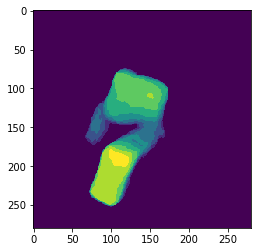

In [15]:

plt.imshow(energy_map[10:-10,10:-10].cpu())
plt.show()

In [16]:
TORCH_ZERO = torch.tensor(0.).to('cuda')
TORCH_ONE = torch.tensor(1.).to('cuda')
def interact_image(angle):
    #unit vectors from origin to detector plane
    vectors = rays - torch.from_numpy(ORIGIN.numpy()[:,None,None]).float().to('cuda')
    #starting positions over every vector
    current_points = ORIGIN.repeat(detector.w,1).view(detector.w,3).repeat(detector.h,1).view(detector.h,detector.w,3).permute(2,1,0).float()
    #placeholders
    energy_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float().to('cuda')
    range_map = torch.from_numpy(np.zeros((detector.w,detector.h))).float().to('cuda')
    INNER_STEP_TORCH = torch.tensor(INNER_STEP).to('cuda')
    vector_normals = (vectors.float() / norm(vectors.float())).to('cuda')
    ORIGIN_TORCH = ORIGIN.float()[:,None,None] .to('cuda')
    for i in range(10):
        min_distance = scene.trace(current_points, angle) 
    #     print(min_distance.min())
        min_distance = torch.where(min_distance>EPSILON, min_distance.float(), INNER_STEP_TORCH)
    #     min_distance = torch.where(min_distance>100, min_distance.float(), torch.tensor(100))
        current_points = torch_displance_point_along_vector(ORIGIN_TORCH, vector_normals, range_map.float()+min_distance.float()) 

        range_map  += min_distance
        energy_map += torch.where(min_distance>EPSILON, TORCH_ZERO, TORCH_ONE)
        if min_distance.min()>10: break
    plt.imshow(energy_map[10:-10,10:-10].cpu().numpy())
    plt.show()

In [17]:

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [20]:
interact(interact_image, angle=(0.0,6.0))

interactive(children=(FloatSlider(value=3.0, description='angle', max=6.0), Output()), _dom_classes=('widget-i…

<function __main__.interact_image(angle)>